In [1]:
!pip install pandas

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [3]:
import numpy as np

class Layer:
    def __init__(self, n_inputs, n_neurons,l1_weightregularizer = 0,l1_biasregularizer = 0,l2_weightregularizer = 0 ,l2_biasregularizer = 0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)               #these are weights of connections going 'to the neuron'
        self.biases = np.zeros((1,n_neurons))                                    #these are biases of neurons in the layer.
        self.l1_weights_regularizer = l1_weightregularizer
        self.l1_biases_regularizer = l1_biasregularizer
        self.l2_weights_regularizer = l2_weightregularizer
        self.l2_biases_regularizer = l2_biasregularizer
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    def backward(self,dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        if(self.l1_weights_regularizer > 0):
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.l1_weights_regularizer * dL1
        if(self.l2_weights_regularizer > 0):
            self.dweights += 2 * self.l2_weights_regularizer * self.weights
        self.dinputs = np.dot(dvalues,self.weights.T)
        if(self.l1_biases_regularizer > 0):
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.l1_biases_regularizer * dL1
        if(self.l2_biases_regularizer > 0):
            self.dbiases += 2 * self.l2_biases_regularizer * self.biases

        self.dinputs = np.dot(dvalues,self.weights.T)

class Activation_ReLU:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0         #relu's derivative

class Activation_Softmax:
    def forward(self,inputs):
        exp_values = np.exp(inputs - np.max(inputs , axis = 1, keepdims=True))
        probabilities = exp_values/np.sum(exp_values,axis=1,keepdims=True)
        self.output = probabilities
    def backward(self,dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output,dvalues)):
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            self.dinputs = np.dot(jacobian_matrix,single_dvalues)
class Loss:
    def regularization_loss(self,layer):

        regularization_loss = 0

        if layer.l1_weights_regularizer > 0:
            regularization_loss += layer.l1_weights_regularizer * np.sum(np.abs(layer.weights))
        if layer.l2_weights_regularizer > 0:
            regularization_loss += layer.l2_weights_regularizer * np.sum(layer.weights ** 2)
        if layer.l1_biases_regularizer > 0:
            regularization_loss += layer.l1_biases_regularizer * np.sum(np.abs(layer.biases))
        if layer.l2_biases_regularizer > 0:
            regularization_loss += layer.l2_biases_regularizer * np.sum(layer.biases ** 2)
        return regularization_loss

    def calculate(self,output,y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CCE(Loss):
    def forward(self,y_pred,y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        if(len(y_true.shape) == 1):
            correct_confidences  =  y_pred_clipped[range(samples), y_true]
        elif(len(y_true.shape) == 2):
            correct_confidences = np.sum(y_pred_clipped*y_true,axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if(len(y_true.shape) == 1):
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true/dvalues
        self.dinputs = self.dinputs/samples


#to make the code faster we combine loss and softmax since they are quite literally the end step

class Softmax_and_Cross_Categroy_Entropy_Loss():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CCE()
    def forward(self,inputs,y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output,y_true)
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis = 1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -= 1
        self.dinputs = self.dinputs/samples

#---------------------------Optimizer---------------------#

class Optimizer_SGD:
    def __init__(self,learning_rate = 0.5,decay = 0.001, momentum = 0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0
    def preupdate(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1/(1+self.decay * self.iterations))
    def update_network(self,layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases
    def postupdate(self):
        self.iterations += 1



In [4]:
import pandas as pd

In [9]:
try:
  df = pd.read_csv('/content/KaggleV2-May-2016.csv')
except FileNotFoundError:
  print('Error: not found')
  exit()
df.dropna(inplace=True)
target_column = 'No-show'
columns_excluded = ['PatientId','AppointmentID']
columns_to_drop = [col for col in columns_excluded if col in df.columns]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['WaitingDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df['WaitingDays'] = np.maximum(0, df['WaitingDays'])

neighbourhood_counts = df['Neighbourhood'].value_counts(normalize=True)
df['Neighbourhood_Frequency'] = df['Neighbourhood'].map(neighbourhood_counts)
df.drop(['ScheduledDay','AppointmentDay','Neighbourhood'], axis=1, inplace=True)
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})
df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})
df.head()
scaler = StandardScaler()
df[['Age']] = scaler.fit_transform(df[['Age']])
df[['WaitingDays']] = scaler.fit_transform(df[['WaitingDays']])
df[['Neighbourhood_Frequency']] = scaler.fit_transform(df[['Neighbourhood_Frequency']])
df.head()



,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays,Neighbourhood_Frequency
0,1,1.077932,0,1,0,0,0,0,0,-0.634346,0.613268
1,0,0.818306,0,0,0,0,0,0,0,-0.634346,0.613268
2,1,1.077932,0,0,0,0,0,0,0,-0.634346,-1.102540
3,1,-1.258708,0,0,0,0,0,0,0,-0.634346,-1.407703
4,1,0.818306,0,1,1,0,0,0,0,-0.634346,0.613268


In [10]:
X = df.drop(target_column, axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:", np.bincount(y_train))
print("y_test distribution:", np.bincount(y_test))

X_train shape: (88421, 10)
X_test shape: (22106, 10)
y_train distribution: [70539 17882]
y_test distribution: [17669  4437]


In [11]:
y_train = np.array(y_train)
y_test = np.array(y_test)

train_accuracies = []
train_losses = []
validation_accuracies = []
validation_losses = []

Layer1 = Layer(X_train.shape[1],64,l1_biasregularizer= 0.01,l2_biasregularizer=0.01,l1_weightregularizer=0.01,l2_weightregularizer=0.01)
ReLu_activation = Activation_ReLU()
Layer2 = Layer(64,32,l1_biasregularizer= 0.01,l2_biasregularizer=0.01,l1_weightregularizer=0.01,l2_weightregularizer=0.01)
ReLu_activation2 = Activation_ReLU()
Layer3 = Layer(32,2,l1_biasregularizer= 0.01,l2_biasregularizer=0.01,l1_weightregularizer=0.01,l2_weightregularizer=0.01)
Softmax_Activation = Activation_Softmax()
loss_activation = Softmax_and_Cross_Categroy_Entropy_Loss()
optimizer = Optimizer_SGD(learning_rate = 0.001)

Layer1.forward(X_test)
ReLu_activation.forward(Layer1.output)
Layer2.forward(ReLu_activation.output)
ReLu_activation2.forward(Layer2.output)
Layer3.forward(ReLu_activation2.output)
loss_test = loss_activation.forward(Layer3.output, y_test)
predictions_test = np.argmax(loss_activation.output, axis=1)
#print("Predictions distribution:", np.bincount(predictions_test))
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy_test = np.mean(predictions_test == y_test)

threshold = 0.2021
import time
start_time = time.time()
for epoch in range(1000):
  Layer1.forward(X_train)
  ReLu_activation.forward(Layer1.output)
  Layer2.forward(ReLu_activation.output)
  ReLu_activation2.forward(Layer2.output)
  Layer3.forward(ReLu_activation2.output)
  data_loss = loss_activation.forward(Layer3.output, y_train)
  regularization_loss = loss_activation.loss.regularization_loss(Layer1)  + loss_activation.loss.regularization_loss(Layer2) + loss_activation.loss.regularization_loss(Layer3)
  loss = data_loss + regularization_loss

  prediction_train_probability = loss_activation.output[:, 1]
  print(prediction_train_probability)
  predictions_train = (prediction_train_probability >= threshold).astype(int)
  y_true_train = np.argmax(y_train, axis=1) if len(y_train.shape) == 2 else y_train
  accuracy_train = np.mean(predictions_train == y_true_train)

  loss_activation.backward(loss_activation.output,y_train)
  Layer3.backward(loss_activation.dinputs)
  ReLu_activation2.backward(Layer3.dinputs)
  Layer2.backward(ReLu_activation2.dinputs)
  ReLu_activation.backward(Layer2.dinputs)
  Layer1.backward(ReLu_activation.dinputs)

  optimizer.preupdate()
  optimizer.update_network(Layer1)
  optimizer.update_network(Layer2)
  optimizer.update_network(Layer3)
  optimizer.postupdate()

  Layer1.forward(X_test)
  ReLu_activation.forward(Layer1.output)
  Layer2.forward(ReLu_activation.output)
  ReLu_activation2.forward(Layer2.output)
  Layer3.forward(ReLu_activation2.output)
  loss_test = loss_activation.forward(Layer3.output, y_test)
  predictions_test_proba = loss_activation.output[:, 1]
  predictions_test = (predictions_test_proba >= threshold).astype(int)
  print(predictions_test)
  y_true_test = np.argmax(y_test, axis=1) if len(y_test.shape) == 2 else y_test
  accuracy_test = np.mean(predictions_test == y_true_test)
  if (epoch%100 == 0):
    print(f'epoch: {epoch}, train_loss: {loss:.4f}, train_acc: {accuracy_train:.4f}, val_loss: {loss_test:.4f}, val_acc: {accuracy_test:.4f}')
  train_accuracies.append(accuracy_train)
  train_losses.append(loss)
  validation_accuracies.append(accuracy_test)
  validation_losses.append(loss_test)
end_time = time.time()
time_nn = end_time - start_time


[0.50000676 0.50000718 0.5000034  ... 0.5000077  0.50000576 0.49999956]
[1 1 1 ... 1 1 1]
epoch: 0, train_loss: 0.9131, train_acc: 0.2022, val_loss: 0.6930, val_acc: 0.2007
[0.49985759 0.49985809 0.4998544  ... 0.4998585  0.49985666 0.49985061]
[1 1 1 ... 1 1 1]
[0.49971386 0.49971423 0.49971053 ... 0.49971477 0.49971289 0.49970669]
[1 1 1 ... 1 1 1]
[0.49957044 0.49957078 0.49956712 ... 0.49957137 0.49956941 0.49956321]
[1 1 1 ... 1 1 1]
[0.49942651 0.49942685 0.49942313 ... 0.49942741 0.49942558 0.49941939]
[1 1 1 ... 1 1 1]
[0.49928298 0.49928329 0.49927971 ... 0.49928389 0.499282   0.49927579]
[1 1 1 ... 1 1 1]
[0.49913926 0.49913957 0.49913601 ... 0.49914014 0.49913837 0.49913217]
[1 1 1 ... 1 1 1]
[0.49899609 0.49899635 0.49899276 ... 0.49899698 0.49899514 0.49898893]
[1 1 1 ... 1 1 1]
[0.49885265 0.49885287 0.49884937 ... 0.49885352 0.49885171 0.49884548]
[1 1 1 ... 1 1 1]
[0.49870929 0.49870952 0.498706   ... 0.49871016 0.49870838 0.49870216]
[1 1 1 ... 1 1 1]
[0.49856618 0.498

In [12]:
print(y_train)

[0 0 1 ... 0 0 0]


In [13]:
import matplotlib.pyplot as plt

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc
Softmax_Activation.forward(Layer3.output)
test_probabilities = Softmax_Activation.output[:, 1]
accuracy = accuracy_score(y_true_test, predictions_test)
f1 = f1_score(y_true_test, predictions_test)
precision, recall, _ = precision_recall_curve(y_true_test, predictions_test_proba)
pr_auc = auc(recall, precision)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")
print(f"Validation PR-AUC: {pr_auc:.4f}")

Validation Accuracy: 0.2007
Validation F1 Score: 0.3343
Validation PR-AUC: 0.2193


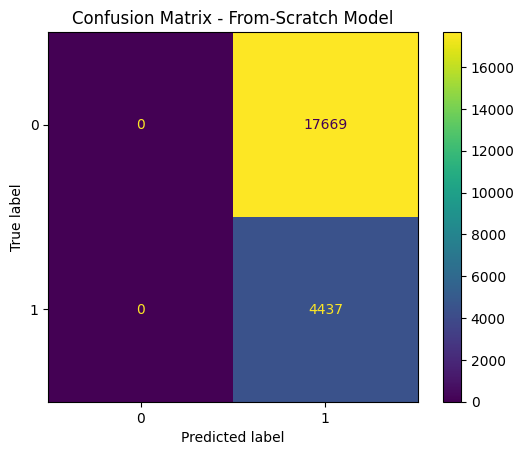

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - From-Scratch Model")
plt.show()

In [17]:
from sklearn.metrics import f1_score
Layer1.forward(X_test)
ReLu_activation.forward(Layer1.output)
Layer2.forward(ReLu_activation.output)
ReLu_activation2.forward(Layer2.output)
Layer3.forward(ReLu_activation2.output)
Softmax_Activation.forward(Layer3.output)

predictions_test_proba = loss_activation.output[:, 1]
predictions_test = (predictions_test_proba <= 0.389477).astype(int)
final_test_predictions = predictions_test

if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)


f1 = f1_score(y_test, final_test_predictions)

print(f"F1 Score on the test set: {f1}")


F1 Score on the test set: 0.33432543420110766


In [35]:
print(time_nn)

457.66857647895813


In [33]:
!pip install torch torchvision torchaudio

  Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [31]:
!pip uninstall numpy -y
!pip install -U numpy

Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.21.0+cu124 requires torch==2.6.0, which is not installed.
peft 0.15.2 requires torch>=1.13.0, which is not installed.
accelerate 1.7.0 requires torch>=2.0.0, which is not installed.
timm 1.0.15 requires torch, which is not installed.
sentence-transformers 4.1.0 requires torch>=1.11.0, which is not installed.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
num_class = 2

model = SimpleNN(input_size, hidden_size1, hidden_size2, num_class)

total_samples = len(y_train)
class_counts = np.bincount(y_train)
raw_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
normalized_weights = raw_weights / raw_weights.sum()
criterion = nn.CrossEntropyLoss(weight=normalized_weights)
optimizer = optim.SGD(model.parameters(), lr=0.001)
epochs = 1000
test_losses = []
test_f1_scores = []
train_losses = []
train_f1_scores = []
start_time_torch = time.time()
for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())

            # Calculate probabilities for the positive class
            test_probabilities = torch.softmax(test_outputs, dim=1)[:, 1].numpy()

            # Use a default threshold for initial F1 calculation
            default_threshold_predictions = (test_probabilities >= 0.5).astype(int)
            test_f1_default = f1_score(y_test_tensor.numpy(), default_threshold_predictions)
            test_f1_scores.append(test_f1_default)
end_time_torch = time.time()
time_torch = end_time_torch - start_time_torch
model.eval()
with torch.no_grad():
  test_outputs = model(X_test_tensor)
  predicted = torch.argmax(torch.softmax(test_outputs.data, 1), 1)
  total = y_test_tensor.size(0)
  correct = (predicted == y_test_tensor).sum().item()
  accuracy = correct / total
  print(f'Test Accuracy: {accuracy * 100:.2f}%')
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test_tensor.numpy(), predicted.numpy())
  print(f'F1 Score on the test set: {f1:.4f}')
  test_probabilities = torch.softmax(test_outputs, dim=1)[:, 1].numpy()
  from sklearn.metrics import precision_recall_curve
  precision, recall, thresholds = precision_recall_curve(y_test_tensor.numpy(), test_probabilities)
  f1_scores_thresholds = 2 * (precision * recall) / (precision + recall + 1e-8)
  best_threshold_index = np.argmax(f1_scores_thresholds)
  best_threshold = thresholds[best_threshold_index]
  best_f1 = f1_scores_thresholds[best_threshold_index]
  predictions_best_threshold = (test_probabilities >= best_threshold).astype(int)
  accuracy_best_threshold = (predictions_best_threshold == y_test_tensor.numpy()).mean()
  print(f'Test Accuracy (using best threshold): {accuracy_best_threshold * 100:.2f}%')
  print("Distribution of predictions (best threshold):", np.bincount(predictions_best_threshold))
  from sklearn.metrics import average_precision_score
  pr_auc = average_precision_score(y_test_tensor.numpy(), test_probabilities)
  print(f'PR-AUC on the test set: {pr_auc:.4f}')
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  cm = confusion_matrix(y_test_tensor.numpy(), predictions_best_threshold)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title("Confusion Matrix - PyTorch Model")
  plt.show()

ValueError: module functions cannot set METH_CLASS or METH_STATIC

For Some reason the above code was'nt running so i opened colab from other account and did it here is the result

It was'nt working on this acc so i did it another notebook
Epoch [100/1000], Loss: 0.6989
Epoch [200/1000], Loss: 0.6980
Epoch [300/1000], Loss: 0.6972
Epoch [400/1000], Loss: 0.6964
Epoch [500/1000], Loss: 0.6957
Epoch [600/1000], Loss: 0.6950
Epoch [700/1000], Loss: 0.6943
Epoch [800/1000], Loss: 0.6937
Epoch [900/1000], Loss: 0.6931
Epoch [1000/1000], Loss: 0.6925
Test Accuracy: 21.12%
F1 Score on the test set: 0.3311
Test Accuracy (using best threshold): 20.16%
Distribution of predictions (best threshold): [   30 22076]
PR-AUC on the test set: 0.2453

print(time_torch)
91.46415042877197